In [2]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Device setup for MPS (Metal Performance Shaders)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define the AdvancedTransform class for training
class AdvancedTransform:
    def __init__(self):
        self.common_augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=1.0),
            A.Affine(
                rotate=(-15, 15),
                translate_percent=(0.1, 0.1),
                scale=(0.8, 1.2),
                shear=10,
                p=0.5
            ),
            A.ElasticTransform(alpha=1.0, sigma=50, p=0.5),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
            A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        ])
        
        self.image_augmentation = A.Compose([
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        ])

    def __call__(self, image, mask):
        seed = random.randint(0, 2**32)
        
        random.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        image = np.array(image)
        mask = np.array(mask)
        
        # Apply transformations
        transformed = self.common_augmentation(image=image, mask=mask)
        image, mask = transformed['image'], transformed['mask']

        image = self.image_augmentation(image=image)['image']

        # Convert numpy array back to PIL image
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        
        return transforms.ToTensor()(image), transforms.ToTensor()(mask)

# Define a simple transform class for validation
class SimpleTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __call__(self, image, mask):
        image = self.transform(image)
        mask = self.transform(mask)
        return image, mask

# Define the KvasirSegDataset class
class KvasirSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image, mask = self.transform(image, mask)
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

# Paths to images and masks
img_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/images'
mask_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/masks'

# Get image and mask paths
image_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir)]
mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]

# Split data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

# Create transform objects
advanced_transform = AdvancedTransform()
simple_transform = SimpleTransform()

# Create datasets with the appropriate transform
train_dataset = KvasirSegDataset(train_image_paths, train_mask_paths, transform=advanced_transform)
val_dataset = KvasirSegDataset(val_image_paths, val_mask_paths, transform=simple_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


Using device: mps


In [3]:
# images masks sorting verification

top_img = []
top_mask = []

for i in image_paths[:5]:
    image = i.split("/")[-1]
    top_img.append(image)

for i in mask_paths[:5]:
    mask = i.split("/")[-1]
    top_mask.append(mask)

print(top_img)
print(top_mask)

['cju83yddek68q0850d2x7zfkm.jpg', 'cju2mfjndoz700988b9lc3zeq.jpg', 'cju7cq6su27qv075574dir0r3.jpg', 'cju5g163vd6mt0817uccuga6u.jpg', 'cju6wjm81vgsc0987enk9n3pr.jpg']
['cju83yddek68q0850d2x7zfkm.jpg', 'cju2mfjndoz700988b9lc3zeq.jpg', 'cju7cq6su27qv075574dir0r3.jpg', 'cju5g163vd6mt0817uccuga6u.jpg', 'cju6wjm81vgsc0987enk9n3pr.jpg']


/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/images/cju83yddek68q0850d2x7zfkm.jpg
(622, 529)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


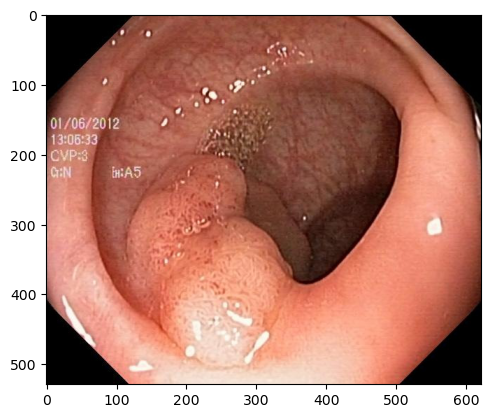

/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/masks/cju83yddek68q0850d2x7zfkm.jpg
(622, 529)


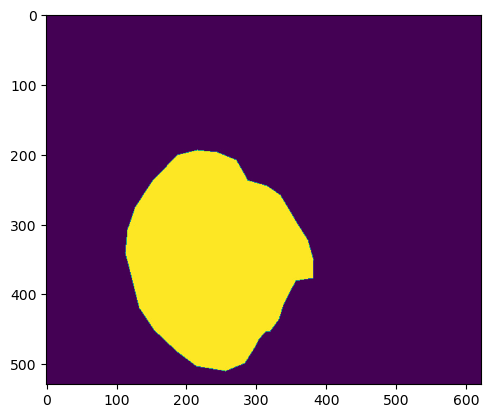

----------------------------------------------------
/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/images/cju2mfjndoz700988b9lc3zeq.jpg
(622, 531)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


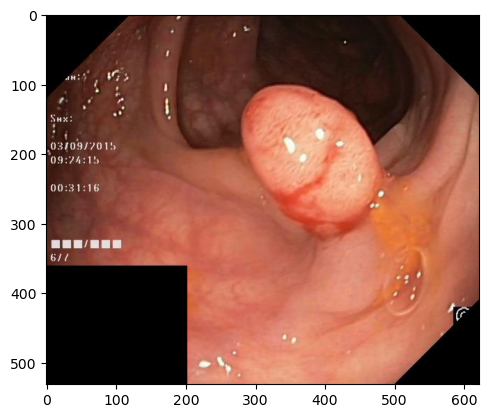

/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/masks/cju2mfjndoz700988b9lc3zeq.jpg
(622, 531)


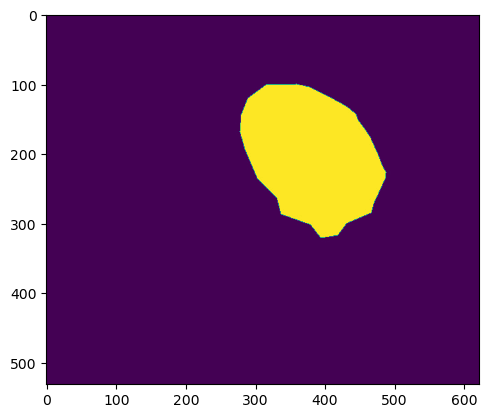

----------------------------------------------------


In [4]:
def show_images(imgs_lst,masks_lst,loops=2):
    for i in range(loops):
        img_path = os.path.join(image_paths[i])
        mask_path = os.path.join(mask_paths[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

show_images(image_paths, mask_paths)

In [5]:
def show_single_img(img=None, mask=None, index=None, train=True):
    if index is not None:
        if train:
            img, mask = train_dataset[index]
        else:
            img, mask = val_dataset[index]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Show the image
    axes[0].imshow(img.permute(1, 2, 0), cmap="gray")  # Convert (3, 512, 512) -> (512, 512, 3)
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Show the mask
    axes[1].imshow(mask.permute(1, 2, 0), cmap="gray")  # Convert (1, 572, 572) -> (572, 572, 1)
    axes[1].set_title('Mask')
    axes[1].axis('off')
    print(mask.shape)

    plt.show()

---------------Train---------------
torch.Size([1, 256, 256])


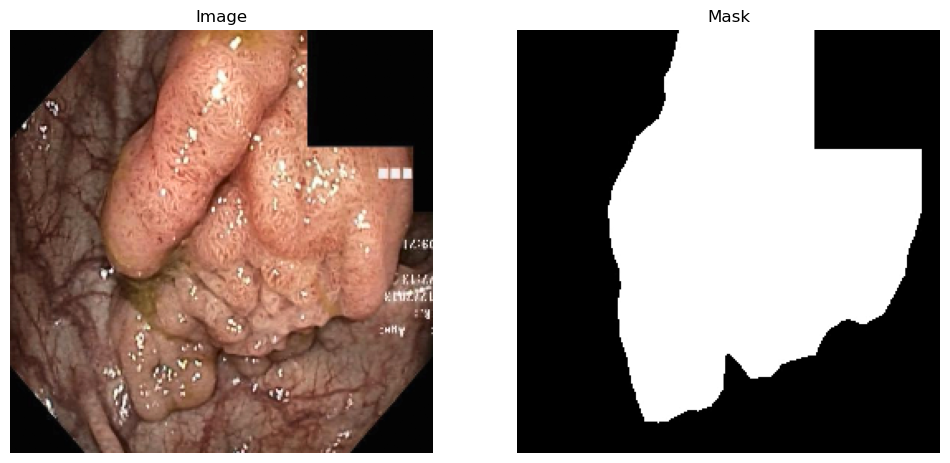

---------------Validation--------------
torch.Size([1, 256, 256])


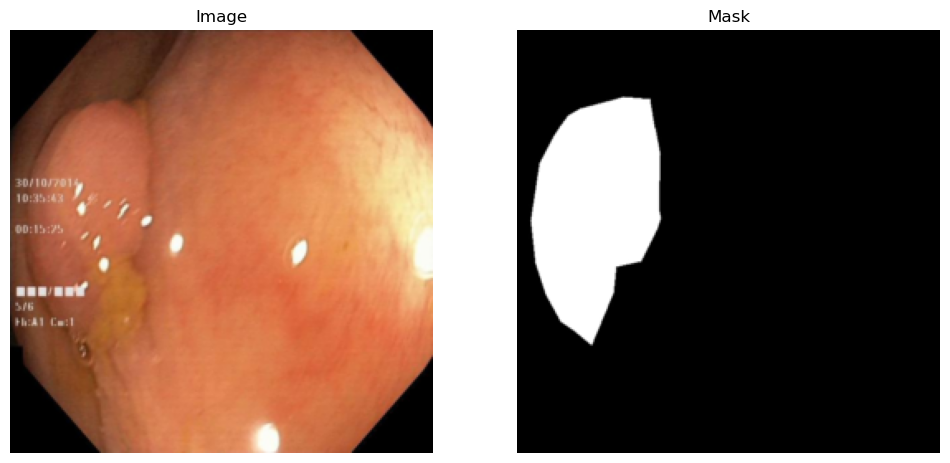

In [6]:
print("---------------Train---------------")
show_single_img(image,mask,index=30,train=True)
print("---------------Validation--------------")
show_single_img(image,mask,index=30,train=False)

### Step 2: Define the U-Net Model

In [8]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down1 = self.conv_block(3, 64)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        self.down5 = self.conv_block(512, 1024)

        self.up1 = self.up_conv_block(1024, 512)
        self.up_conv1 = self.conv_block(1024, 512)
        self.up2 = self.up_conv_block(512, 256)
        self.up_conv2 = self.conv_block(512, 256)
        self.up3 = self.up_conv_block(256, 128)
        self.up_conv3 = self.conv_block(256, 128)
        self.up4 = self.up_conv_block(128, 64)
        self.up_conv4 = self.conv_block(128, 64)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def up_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(nn.functional.max_pool2d(down1, 2))
        down3 = self.down3(nn.functional.max_pool2d(down2, 2))
        down4 = self.down4(nn.functional.max_pool2d(down3, 2))
        down5 = self.down5(nn.functional.max_pool2d(down4, 2))

        up1 = self.up1(down5)
        up1 = torch.cat([up1, down4], dim=1)
        up1 = self.up_conv1(up1)
        up2 = self.up2(up1)
        up2 = torch.cat([up2, down3], dim=1)
        up2 = self.up_conv2(up2)
        up3 = self.up3(up2)
        up3 = torch.cat([up3, down2], dim=1)
        up3 = self.up_conv3(up3)
        up4 = self.up4(up3)
        up4 = torch.cat([up4, down1], dim=1)
        up4 = self.up_conv4(up4)

        out = self.final_conv(up4)
        return self.sigmoid(out)

### Step 3: Training Loop with Metrics and Plotting

In [15]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm


ADV_Aug_SGD_BCE_model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(ADV_Aug_SGD_BCE_model.parameters(), lr=0.01, momentum=0.9)

def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    return dice.mean()

def iou(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = (pred + target).sum(dim=2).sum(dim=2) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [16]:
num_epochs = 25
train_losses = []
val_losses = []  # To store validation loss
val_dice_scores = []
val_ious = []

for epoch in range(num_epochs):
    ADV_Aug_SGD_BCE_model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = ADV_Aug_SGD_BCE_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation
    ADV_Aug_SGD_BCE_model.eval()
    val_loss = 0.0  # Initialize validation loss
    val_dice = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = ADV_Aug_SGD_BCE_model(images)
            loss = criterion(outputs, masks)  # Compute validation loss
            val_loss += loss.item() * images.size(0)
            preds = outputs > 0.5
            val_dice += dice_coefficient(preds, masks).item() * images.size(0)
            val_iou += iou(preds, masks).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store validation loss
    val_dice /= len(val_loader.dataset)
    val_dice_scores.append(val_dice)
    val_iou /= len(val_loader.dataset)
    val_ious.append(val_iou)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

Epoch 1/25: 100%|█████████████████████████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch [1/25], Loss: 0.4422
Epoch [1/25], Validation Loss: 0.3563, Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 2/25: 100%|█████████████████████████████| 200/200 [02:14<00:00,  1.48it/s]


Epoch [2/25], Loss: 0.3878
Epoch [2/25], Validation Loss: 0.3460, Validation Dice: 0.0003, Validation IoU: 0.0002


Epoch 3/25: 100%|█████████████████████████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch [3/25], Loss: 0.3765
Epoch [3/25], Validation Loss: 0.3543, Validation Dice: 0.0005, Validation IoU: 0.0003


Epoch 4/25: 100%|█████████████████████████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch [4/25], Loss: 0.3757
Epoch [4/25], Validation Loss: 1.2222, Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 5/25: 100%|█████████████████████████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch [5/25], Loss: 0.3643
Epoch [5/25], Validation Loss: 0.3334, Validation Dice: 0.1702, Validation IoU: 0.1128


Epoch 6/25: 100%|█████████████████████████████| 200/200 [02:15<00:00,  1.47it/s]


Epoch [6/25], Loss: 0.3691
Epoch [6/25], Validation Loss: 0.3315, Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 7/25: 100%|█████████████████████████████| 200/200 [02:15<00:00,  1.47it/s]


Epoch [7/25], Loss: 0.3617
Epoch [7/25], Validation Loss: 0.3182, Validation Dice: 0.0332, Validation IoU: 0.0190


Epoch 8/25: 100%|█████████████████████████████| 200/200 [02:14<00:00,  1.48it/s]


Epoch [8/25], Loss: 0.3537
Epoch [8/25], Validation Loss: 0.3088, Validation Dice: 0.4266, Validation IoU: 0.3129


Epoch 9/25: 100%|█████████████████████████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch [9/25], Loss: 0.3425
Epoch [9/25], Validation Loss: 0.3103, Validation Dice: 0.4556, Validation IoU: 0.3358


Epoch 10/25: 100%|████████████████████████████| 200/200 [02:12<00:00,  1.51it/s]


Epoch [10/25], Loss: 0.3436
Epoch [10/25], Validation Loss: 0.2871, Validation Dice: 0.4004, Validation IoU: 0.2979


Epoch 11/25: 100%|████████████████████████████| 200/200 [02:15<00:00,  1.47it/s]


Epoch [11/25], Loss: 0.3261
Epoch [11/25], Validation Loss: 0.2790, Validation Dice: 0.4563, Validation IoU: 0.3516


Epoch 12/25: 100%|████████████████████████████| 200/200 [02:16<00:00,  1.47it/s]


Epoch [12/25], Loss: 0.3172
Epoch [12/25], Validation Loss: 0.2761, Validation Dice: 0.3642, Validation IoU: 0.2775


Epoch 13/25: 100%|████████████████████████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch [13/25], Loss: 0.2979
Epoch [13/25], Validation Loss: 0.2581, Validation Dice: 0.5406, Validation IoU: 0.4223


Epoch 14/25: 100%|████████████████████████████| 200/200 [02:16<00:00,  1.46it/s]


Epoch [14/25], Loss: 0.2826
Epoch [14/25], Validation Loss: 0.2824, Validation Dice: 0.4378, Validation IoU: 0.3462


Epoch 15/25: 100%|████████████████████████████| 200/200 [02:14<00:00,  1.48it/s]


Epoch [15/25], Loss: 0.2801
Epoch [15/25], Validation Loss: 0.2279, Validation Dice: 0.6271, Validation IoU: 0.5073


Epoch 16/25: 100%|████████████████████████████| 200/200 [02:13<00:00,  1.49it/s]


Epoch [16/25], Loss: 0.2687
Epoch [16/25], Validation Loss: 0.2329, Validation Dice: 0.6500, Validation IoU: 0.5254


Epoch 17/25: 100%|████████████████████████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch [17/25], Loss: 0.2594
Epoch [17/25], Validation Loss: 0.2213, Validation Dice: 0.6259, Validation IoU: 0.5231


Epoch 18/25: 100%|████████████████████████████| 200/200 [02:15<00:00,  1.47it/s]


Epoch [18/25], Loss: 0.2663
Epoch [18/25], Validation Loss: 0.2199, Validation Dice: 0.5978, Validation IoU: 0.4932


Epoch 19/25: 100%|████████████████████████████| 200/200 [02:16<00:00,  1.47it/s]


Epoch [19/25], Loss: 0.2578
Epoch [19/25], Validation Loss: 0.2177, Validation Dice: 0.6779, Validation IoU: 0.5600


Epoch 20/25: 100%|████████████████████████████| 200/200 [02:16<00:00,  1.47it/s]


Epoch [20/25], Loss: 0.2511
Epoch [20/25], Validation Loss: 0.1960, Validation Dice: 0.6925, Validation IoU: 0.5893


Epoch 21/25: 100%|████████████████████████████| 200/200 [02:14<00:00,  1.48it/s]


Epoch [21/25], Loss: 0.2501
Epoch [21/25], Validation Loss: 0.2001, Validation Dice: 0.7278, Validation IoU: 0.6232


Epoch 22/25: 100%|████████████████████████████| 200/200 [02:16<00:00,  1.46it/s]


Epoch [22/25], Loss: 0.2460
Epoch [22/25], Validation Loss: 0.1881, Validation Dice: 0.7171, Validation IoU: 0.6127


Epoch 23/25: 100%|████████████████████████████| 200/200 [02:14<00:00,  1.48it/s]


Epoch [23/25], Loss: 0.2319
Epoch [23/25], Validation Loss: 0.2184, Validation Dice: 0.6645, Validation IoU: 0.5667


Epoch 24/25: 100%|████████████████████████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch [24/25], Loss: 0.2333
Epoch [24/25], Validation Loss: 0.1966, Validation Dice: 0.7353, Validation IoU: 0.6366


Epoch 25/25: 100%|████████████████████████████| 200/200 [02:16<00:00,  1.47it/s]


Epoch [25/25], Loss: 0.2241
Epoch [25/25], Validation Loss: 0.1827, Validation Dice: 0.7232, Validation IoU: 0.6248


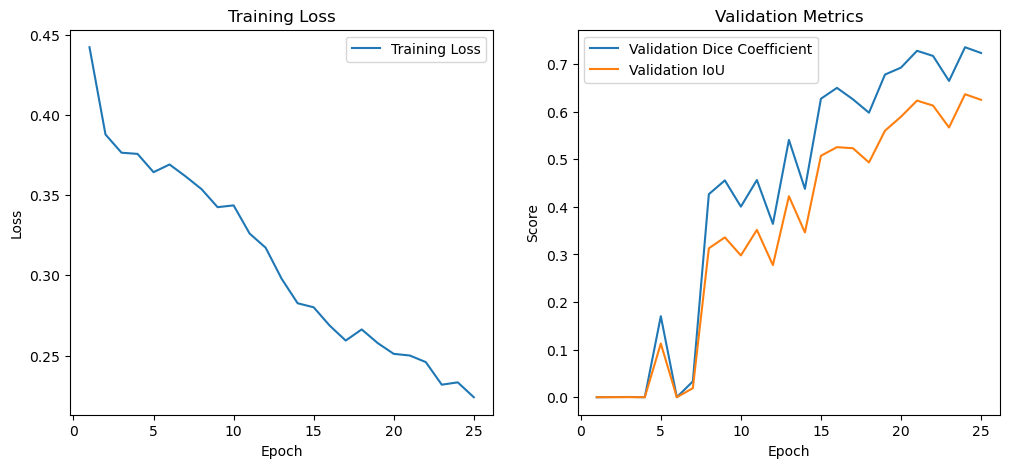

In [17]:
# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_dice_scores, label='Validation Dice Coefficient')
plt.plot(range(1, num_epochs + 1), val_ious, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Metrics')

plt.show()

In [18]:
for epoch in range(num_epochs):
    ADV_Aug_SGD_BCE_model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = ADV_Aug_SGD_BCE_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation
    ADV_Aug_SGD_BCE_model.eval()
    val_loss = 0.0  # Initialize validation loss
    val_dice = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = ADV_Aug_SGD_BCE_model(images)
            loss = criterion(outputs, masks)  # Compute validation loss
            val_loss += loss.item() * images.size(0)
            preds = outputs > 0.5
            val_dice += dice_coefficient(preds, masks).item() * images.size(0)
            val_iou += iou(preds, masks).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store validation loss
    val_dice /= len(val_loader.dataset)
    val_dice_scores.append(val_dice)
    val_iou /= len(val_loader.dataset)
    val_ious.append(val_iou)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

Epoch 1/25: 100%|█████████████████████████████| 200/200 [02:16<00:00,  1.47it/s]


Epoch [1/25], Loss: 0.2314
Epoch [1/25], Validation Loss: 0.1970, Validation Dice: 0.7283, Validation IoU: 0.6203


Epoch 2/25: 100%|█████████████████████████████| 200/200 [02:15<00:00,  1.47it/s]


Epoch [2/25], Loss: 0.2327
Epoch [2/25], Validation Loss: 0.1913, Validation Dice: 0.7190, Validation IoU: 0.6215


Epoch 3/25: 100%|█████████████████████████████| 200/200 [02:15<00:00,  1.47it/s]


Epoch [3/25], Loss: 0.2219
Epoch [3/25], Validation Loss: 0.1755, Validation Dice: 0.7699, Validation IoU: 0.6705


Epoch 4/25: 100%|█████████████████████████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch [4/25], Loss: 0.2208
Epoch [4/25], Validation Loss: 0.1760, Validation Dice: 0.7663, Validation IoU: 0.6621


Epoch 5/25: 100%|█████████████████████████████| 200/200 [02:16<00:00,  1.46it/s]


Epoch [5/25], Loss: 0.2226
Epoch [5/25], Validation Loss: 0.1735, Validation Dice: 0.7509, Validation IoU: 0.6515


Epoch 6/25: 100%|█████████████████████████████| 200/200 [02:15<00:00,  1.47it/s]


Epoch [6/25], Loss: 0.2151
Epoch [6/25], Validation Loss: 0.1885, Validation Dice: 0.7250, Validation IoU: 0.6328


Epoch 7/25: 100%|█████████████████████████████| 200/200 [02:16<00:00,  1.47it/s]


Epoch [7/25], Loss: 0.2201
Epoch [7/25], Validation Loss: 0.1648, Validation Dice: 0.7784, Validation IoU: 0.6770


Epoch 8/25: 100%|█████████████████████████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch [8/25], Loss: 0.2186
Epoch [8/25], Validation Loss: 0.1911, Validation Dice: 0.7466, Validation IoU: 0.6433


Epoch 9/25: 100%|█████████████████████████████| 200/200 [02:16<00:00,  1.47it/s]


Epoch [9/25], Loss: 0.2138
Epoch [9/25], Validation Loss: 0.1553, Validation Dice: 0.7880, Validation IoU: 0.6922


Epoch 10/25: 100%|████████████████████████████| 200/200 [02:17<00:00,  1.46it/s]


Epoch [10/25], Loss: 0.2122
Epoch [10/25], Validation Loss: 0.1723, Validation Dice: 0.7753, Validation IoU: 0.6752


Epoch 11/25: 100%|████████████████████████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch [11/25], Loss: 0.2112
Epoch [11/25], Validation Loss: 0.1764, Validation Dice: 0.7662, Validation IoU: 0.6636


Epoch 12/25: 100%|████████████████████████████| 200/200 [02:14<00:00,  1.48it/s]


Epoch [12/25], Loss: 0.2051
Epoch [12/25], Validation Loss: 0.1686, Validation Dice: 0.7771, Validation IoU: 0.6763


Epoch 13/25: 100%|████████████████████████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch [13/25], Loss: 0.2039
Epoch [13/25], Validation Loss: 0.1617, Validation Dice: 0.7660, Validation IoU: 0.6760


Epoch 14/25: 100%|████████████████████████████| 200/200 [02:16<00:00,  1.46it/s]


Epoch [14/25], Loss: 0.2047
Epoch [14/25], Validation Loss: 0.1682, Validation Dice: 0.7577, Validation IoU: 0.6591


Epoch 15/25: 100%|████████████████████████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch [15/25], Loss: 0.2060
Epoch [15/25], Validation Loss: 0.1487, Validation Dice: 0.7929, Validation IoU: 0.7023


Epoch 16/25: 100%|████████████████████████████| 200/200 [02:14<00:00,  1.48it/s]


Epoch [16/25], Loss: 0.1942
Epoch [16/25], Validation Loss: 0.1702, Validation Dice: 0.7744, Validation IoU: 0.6703


Epoch 17/25: 100%|████████████████████████████| 200/200 [02:16<00:00,  1.47it/s]


Epoch [17/25], Loss: 0.2000
Epoch [17/25], Validation Loss: 0.1669, Validation Dice: 0.7816, Validation IoU: 0.6784


Epoch 18/25: 100%|████████████████████████████| 200/200 [02:15<00:00,  1.47it/s]


Epoch [18/25], Loss: 0.1962
Epoch [18/25], Validation Loss: 0.1791, Validation Dice: 0.7525, Validation IoU: 0.6487


Epoch 19/25: 100%|████████████████████████████| 200/200 [02:16<00:00,  1.47it/s]


Epoch [19/25], Loss: 0.2001
Epoch [19/25], Validation Loss: 0.1487, Validation Dice: 0.8116, Validation IoU: 0.7208


Epoch 20/25: 100%|████████████████████████████| 200/200 [02:13<00:00,  1.50it/s]


Epoch [20/25], Loss: 0.1938
Epoch [20/25], Validation Loss: 0.1443, Validation Dice: 0.7953, Validation IoU: 0.7082


Epoch 21/25: 100%|████████████████████████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch [21/25], Loss: 0.1981
Epoch [21/25], Validation Loss: 0.1486, Validation Dice: 0.8048, Validation IoU: 0.7117


Epoch 22/25: 100%|████████████████████████████| 200/200 [02:15<00:00,  1.48it/s]


Epoch [22/25], Loss: 0.1879
Epoch [22/25], Validation Loss: 0.1527, Validation Dice: 0.7895, Validation IoU: 0.6938


Epoch 23/25: 100%|████████████████████████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch [23/25], Loss: 0.1915
Epoch [23/25], Validation Loss: 0.1472, Validation Dice: 0.7890, Validation IoU: 0.7010


Epoch 24/25: 100%|████████████████████████████| 200/200 [02:16<00:00,  1.47it/s]


Epoch [24/25], Loss: 0.1863
Epoch [24/25], Validation Loss: 0.1484, Validation Dice: 0.7912, Validation IoU: 0.6981


Epoch 25/25: 100%|████████████████████████████| 200/200 [02:14<00:00,  1.49it/s]


Epoch [25/25], Loss: 0.1945
Epoch [25/25], Validation Loss: 0.1501, Validation Dice: 0.7798, Validation IoU: 0.6940


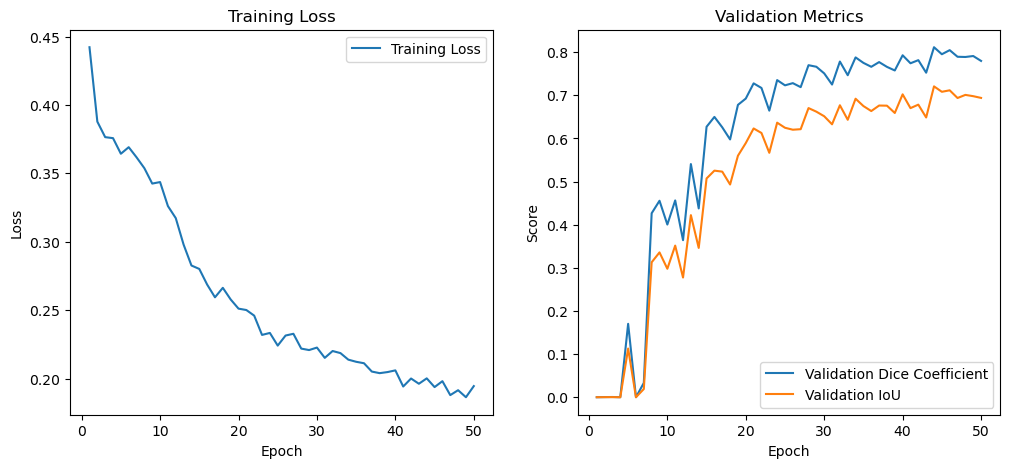

In [25]:
# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 50 + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, 50 + 1), val_dice_scores, label='Validation Dice Coefficient')
plt.plot(range(1, 50 + 1), val_ious, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Metrics')

plt.show()